In [1]:
import torch
import qtorch_plus

Using /home/yg9bq/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Emitting ninja build file /home/yg9bq/.cache/torch_extensions/py310_cu118/quant_cpu/build.ninja...
Building extension module quant_cpu...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module quant_cpu...
Using /home/yg9bq/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...


ninja: no work to do.


Detected CUDA files, patching ldflags
Emitting ninja build file /home/yg9bq/.cache/torch_extensions/py310_cu118/quant_cuda/build.ninja...
/home/yg9bq/miniconda3/envs/posit/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module quant_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module quant_cuda...


In [2]:
from qtorch_plus.quant import fixed_point_quantize, block_quantize, float_quantize, posit_quantize

In [3]:
# Set the random seed for reproducibility
torch.manual_seed(123)

full_precision_tensor = torch.rand(5)
print("Full Precision: {}".format(full_precision_tensor))
low_precision_tensor = posit_quantize(full_precision_tensor, nsize=8, es=2)
print("Low Precision: {}".format(low_precision_tensor))
low_precision_tensor1 = posit_quantize(full_precision_tensor, nsize=8, es=1)
print("Low Precision: {}".format(low_precision_tensor1))
low_precision_tensor2 = posit_quantize(full_precision_tensor, nsize=8, es=0)
print("Low Precision: {}".format(low_precision_tensor2))


Full Precision: tensor([0.2961, 0.5166, 0.2517, 0.6886, 0.0740])
Low Precision: tensor([0.2812, 0.5000, 0.2500, 0.6875, 0.0703])
Low Precision: tensor([0.2969, 0.5312, 0.2500, 0.6875, 0.0703])
Low Precision: tensor([0.2969, 0.5156, 0.2500, 0.6875, 0.0781])


In [4]:
# Calculate the absolute differences
diff1 = torch.abs(full_precision_tensor - low_precision_tensor)
diff2 = torch.abs(full_precision_tensor - low_precision_tensor1)
diff3 = torch.abs(full_precision_tensor - low_precision_tensor2)

# Print the results
print("Absolute difference (es=2):", diff1)
print("Absolute difference (es=1):", diff2)
print("Absolute difference (es=0):", diff3)

Absolute difference (es=2): tensor([0.0149, 0.0166, 0.0017, 0.0011, 0.0037])
Absolute difference (es=1): tensor([0.0008, 0.0147, 0.0017, 0.0011, 0.0037])
Absolute difference (es=0): tensor([0.0008, 0.0009, 0.0017, 0.0011, 0.0042])


In [46]:
from transformers import GPT2Model, GPT2Tokenizer

# Load GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

print(model)

first_layer_weights = model.h[1].attn.c_attn.weight

print("First Layer Weights Shape:", first_layer_weights.shape)
print("First Layer Weights (Sample):", first_layer_weights[:5])


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)
First Layer Weights Shape: torch.Size([768, 2304])
First Layer Weights (Sample): tensor([[-0.2906,  0.3057,  0.0302,  ..., -0.0057, -0.0582, -0.0061],
        [-0.3272,  0.2420,  0.2140,  ..., -0.0100

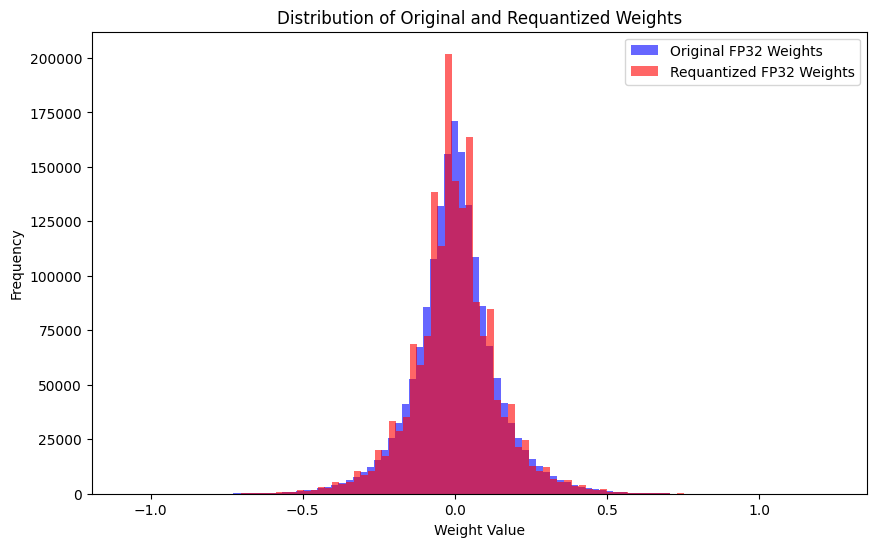

In [47]:
import matplotlib.pyplot as plt

def quantize_to_int8(fp32_tensor):
    min_val = fp32_tensor.min().item()
    max_val = fp32_tensor.max().item()
    scale = 127.0 / max(abs(min_val), abs(max_val))
    int8_tensor = torch.clamp((fp32_tensor * scale).round(), -128, 127).to(torch.int8)
    fp32_requantized = int8_tensor.float() / scale
    return int8_tensor, fp32_requantized

int8_weights, fp32_requantized_weights = quantize_to_int8(first_layer_weights)


# List the first 10 original weights and the first 10 dequantized weights
original_weights = first_layer_weights.flatten()[:10]
requantized_weights = fp32_requantized_weights.flatten()[:10]

# Plot the distribution of the original and requantized weights on the same figure
plt.figure(figsize=(10, 6))
plt.hist(first_layer_weights.detach().cpu().numpy().flatten(), bins=100, color='blue', alpha=0.6, label='Original FP32 Weights')
plt.hist(fp32_requantized_weights.detach().cpu().numpy().flatten(), bins=100, color='red', alpha=0.6, label='Requantized FP32 Weights')
plt.title("Distribution of Original and Requantized Weights")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

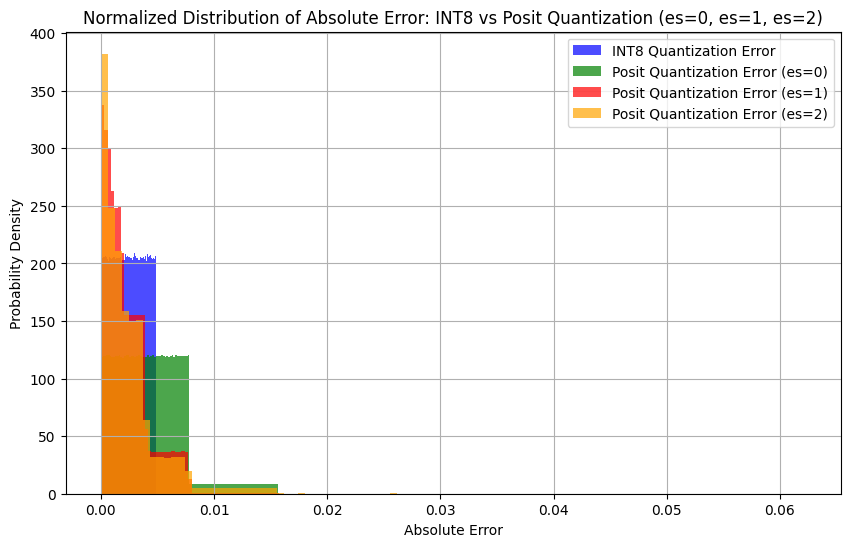

In [48]:
# Assuming posit_quantize is already defined in your environment

# Posit quantization for different values of es
posit_quantized_weight_es0 = posit_quantize(first_layer_weights, nsize=8, es=0)
posit_quantized_weight_es1 = posit_quantize(first_layer_weights, nsize=8, es=1)
posit_quantized_weight_es2 = posit_quantize(first_layer_weights, nsize=8, es=2)

# Calculate the absolute error between original and INT8 quantized weights
absolute_error_int8 = torch.abs(first_layer_weights - fp32_requantized_weights)

# Calculate the absolute error between original and Posit quantized weights for different es values
absolute_error_posit_es0 = torch.abs(first_layer_weights - posit_quantized_weight_es0)
absolute_error_posit_es1 = torch.abs(first_layer_weights - posit_quantized_weight_es1)
absolute_error_posit_es2 = torch.abs(first_layer_weights - posit_quantized_weight_es2)

# Plot the distribution of the absolute errors for INT8 and different Posit quantizations
plt.figure(figsize=(10, 6))
plt.hist(absolute_error_int8.detach().cpu().numpy().flatten(), bins=100, color='blue', alpha=0.7, label='INT8 Quantization Error', density=True)
plt.hist(absolute_error_posit_es0.detach().cpu().numpy().flatten(), bins=100, color='green', alpha=0.7, label='Posit Quantization Error (es=0)', density=True)
plt.hist(absolute_error_posit_es1.detach().cpu().numpy().flatten(), bins=100, color='red', alpha=0.7, label='Posit Quantization Error (es=1)', density=True)
plt.hist(absolute_error_posit_es2.detach().cpu().numpy().flatten(), bins=100, color='orange', alpha=0.7, label='Posit Quantization Error (es=2)', density=True)

# Add titles and labels
plt.title("Normalized Distribution of Absolute Error: INT8 vs Posit Quantization (es=0, es=1, es=2)")
plt.xlabel("Absolute Error")
plt.ylabel("Probability Density")  # Update y-axis label to reflect normalization
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


In [49]:
# Calculate the mean absolute error for INT8 quantization
mean_error_int8 = absolute_error_int8.mean().item()

# Calculate the mean absolute error for Posit quantization with es=0, es=1, and es=2
mean_error_posit_es0 = absolute_error_posit_es0.mean().item()
mean_error_posit_es1 = absolute_error_posit_es1.mean().item()
mean_error_posit_es2 = absolute_error_posit_es2.mean().item()

# Print the average error for each quantization method
print(f"Mean Absolute Error (       INT8): {mean_error_int8}")
print(f"Mean Absolute Error (Posit, es=0): {mean_error_posit_es0}")
print(f"Mean Absolute Error (Posit, es=1): {mean_error_posit_es1}")
print(f"Mean Absolute Error (Posit, es=2): {mean_error_posit_es2}")


Mean Absolute Error (       INT8): 0.0024383272975683212
Mean Absolute Error (Posit, es=0): 0.00442048953846097
Mean Absolute Error (Posit, es=1): 0.0022571454755961895
Mean Absolute Error (Posit, es=2): 0.002545986557379365
